
# Predictive Modeling of Patient Waiting Times in Emergency Department

The "Waiting Time Model" notebook explores data related to patient admissions in emergency medicine. With an increasing demand for healthcare services, understanding and optimizing waiting times has become crucial for enhancing patient satisfaction and operational efficiency. This analysis utilizes various machine learning techniques to predict waiting times based on a variety of factors such as arrival time, severity level, and patient demographics.
The dataset consists of over 93,000 entries from the Royal Commission Health Services Program, encompassing a wide range of attributes that provide insights into the admissions process. By leveraging this data, we aim to uncover patterns and develop predictive models that can assist healthcare providers in managing patient flow more effectively.

**Objective**: The main objectives of this notebook are:
1. Data Exploration: Conduct an exploratory data analysis (EDA) to understand the dataset's structure, identify unique values, and recognize patterns in the data.
2. Data Preprocessing: Clean and preprocess the data to make it suitable for analysis, including handling missing values and converting date-time fields.
3. Feature Engineering: Create new features that may enhance the model's performance, such as time of day, arrival hour, and the day of the week.
4. Model Development: Implement various machine learning models, including Linear Regression, Random Forest, and Gradient Boosting, to predict waiting times.
5. Model Evaluation: Assess the performance of the developed models using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score.
6. Insights and Recommendations: Derive actionable insights from the analysis to help healthcare providers improve patient management and reduce waiting times.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import pickle
from sklearn.preprocessing import LabelEncoder

import warnings  # The warnings module to handle warnings during code execution

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../Data/data_after_EDA2.csv')

# Convert date-time columns to datetime objects for easier manipulation
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Discharge Time'] = pd.to_datetime(data['Discharge Time'])
data.head()

,index,ROWNUM,Hospital,Eligibility Class,Gender,Arrival Time,Severity Level,Deparment,Main Diagnosis,Discharge Time,Waiting Time (Minutes),Length of Stay (Minutes),Treatment Time(Minutes),Cluster,No Treatment
0,0,1,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-12-13 13:17:48,Level Ⅳ,Emergency Medicine,"Pain, unspecified",2023-12-13 16:43:00,14.0,205.0,191.0,2,0
1,1,2,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-12-08 10:59:28,Level Ⅲ,Emergency Medicine,Low back pain,2023-12-08 12:50:00,7.0,111.0,104.0,1,0
2,2,3,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-11-05 14:03:02,Level Ⅲ,Emergency Medicine,"Acute upper respiratory infection, unspecified",2023-11-05 14:54:00,24.0,51.0,27.0,1,0
3,3,4,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-10-07 22:57:41,Level Ⅲ,Emergency Medicine,Epistaxis,2023-10-08 00:09:00,26.0,71.0,0.0,1,1
4,4,5,Royal Commission Health Services Program,ROYAL COMMISSION,Female,2023-10-21 21:32:17,Level Ⅳ,Emergency Medicine,"Acute upper respiratory infection, unspecified",2023-10-21 23:10:00,56.0,98.0,42.0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93189 entries, 0 to 93188
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   index                     93189 non-null  int64         
 1   ROWNUM                    93189 non-null  object        
 2   Hospital                  93189 non-null  object        
 3   Eligibility Class         93189 non-null  object        
 4   Gender                    93189 non-null  object        
 5   Arrival Time              93189 non-null  datetime64[ns]
 6   Severity Level            93189 non-null  object        
 7   Deparment                 93189 non-null  object        
 8   Main Diagnosis            93189 non-null  object        
 9   Discharge Time            93189 non-null  datetime64[ns]
 10  Waiting Time (Minutes)    93189 non-null  float64       
 11  Length of Stay (Minutes)  93189 non-null  float64       
 12  Treatment Time(Min

In [4]:
# Display the number of unique values for each column
unique_values = data.nunique()

# Print the result
print(unique_values)

index                       93189
ROWNUM                      93189
Hospital                        1
Eligibility Class               4
Gender                          2
Arrival Time                93177
Severity Level                  5
Deparment                       1
Main Diagnosis               1779
Discharge Time              83548
Waiting Time (Minutes)         68
Length of Stay (Minutes)      232
Treatment Time(Minutes)       814
Cluster                         3
No Treatment                    2
dtype: int64


Summary of Unique Values in Each Column: 

<dd>1- ROWNUM: 93,189 (This likely represents the total number of records in the dataset)</dd>
<dd>2- Hospital: 1 (All records belong to a single hospital, "Royal Commission Health Services Program.")</dd>
<dd>3- Eligibility Class: 4 (There are four different eligibility classes for patients.)</dd>
<dd>4- Gender: 2 ("Male" and "Female.")</dd>
<dd>5- Arrival Time: 97,081 (Indicates that some patients may have arrived at the same time, as there are only 15 unique timestamps.)</dd>
<dd>6- Severity Level: 5 (There are five different severity levels, likely ranging from Level I to Level V.)</dd>
<dd>7- Deparment: 1 (All patients are admitted to "Emergency Medicine," indicating a focus on a specific area of care.)</dd>
<dd>8- Main Diagnosis: 1,779 (A diverse range of diagnoses, with a large number indicating complexity in patient conditions.)</dd>
<dd>9- Discharge Time: 83,548 (Similar to Arrival Time, indicating that many patients were discharged at the same times.)</dd>
<dd>10- Waiting Time (Minutes): 68 (Shows some variability in waiting times, but many are likely similar, given the range.)</dd>
<dd>11- Length of Stay (Minutes): 232 (Indicates that patients have varied lengths of stay in the hospital.)</dd>
<dd>12- Treatment Time (Minutes): 814 (Indicates that patients have varied time of treatment in the hospital.)</dd>

Given that both Hospital and Department columns contain only one unique value, and ROWNUM serves as an index, we should drop all three columns to streamline your dataset and focus on the features that contribute meaningfully to your analysis.

In [5]:
# Sort DataFrame by Arrival Time
data = data.sort_values('Arrival Time')

# Initialize a list to store the count of admitted patients
admitted_patients = []

# Loop through each row to calculate current admitted patients
for index, row in data.iterrows():
    # Count how many patients are currently admitted
    count = data[(data['Arrival Time'] <= row['Arrival Time']) & 
                 (data['Discharge Time'] >= row['Arrival Time'])].shape[0]
    admitted_patients.append(count)

# Add the new column to the DataFrame
data['Currently Admitted Patients'] = admitted_patients

# Display the DataFrame with the new column
print(data[['Arrival Time', 'Discharge Time', 'Currently Admitted Patients']])

# Sort DataFrame by Arrival Time
data = data.sort_values('ROWNUM')

# Verify the changes
print(data.head())
data.shape

             Arrival Time      Discharge Time  Currently Admitted Patients
22930 2023-01-01 00:05:24 2023-01-01 01:08:00                            1
28110 2023-01-01 00:05:55 2023-01-01 01:10:00                            2
62426 2023-01-01 00:07:03 2023-01-01 01:20:00                            3
79608 2023-01-01 00:12:54 2023-01-01 01:11:00                            4
61630 2023-01-01 00:19:13 2023-01-01 01:13:00                            5
...                   ...                 ...                          ...
91716 2023-12-31 23:45:51 2024-01-01 00:41:00                           31
52320 2023-12-31 23:48:46 2024-01-01 03:49:46                           32
76965 2023-12-31 23:53:53 2024-01-01 01:15:00                           32
16318 2023-12-31 23:54:15 2024-01-01 00:29:00                           33
25282 2023-12-31 23:56:09 2024-01-01 00:29:00                           30

[93189 rows x 3 columns]
     index ROWNUM                                  Hospital Eligibility Cl

(93189, 16)

In [6]:
# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Discharge Time'] = pd.to_datetime(data['Discharge Time'], errors='coerce')

# Feature 1: Arrival Date
data['Arrival Date'] = data['Arrival Time'].dt.date

# Feature 2: Arrival Hour
data['Arrival Hour'] = data['Arrival Time'].dt.hour

# Feature 3: Day of the Week
data['Day of Week'] = data['Arrival Time'].dt.day_name()

# Feature 4: Is Weekend
data['Is Weekend'] = data['Day of Week'].apply(lambda x: 1 if x in ['Saturday', 'Friday'] else 0)



# Feature 6: Time of Day
def time_of_day(hour):
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['Time of Day'] = data['Arrival Hour'].apply(time_of_day)

# Display the first few rows with the new features
print(data[['Arrival Time', 'Arrival Date', 'Arrival Hour', 'Day of Week', 'Is Weekend', 'Time of Day']].head())


           Arrival Time Arrival Date  Arrival Hour Day of Week  Is Weekend  \
0   2023-12-13 13:17:48   2023-12-13            13   Wednesday           0   
964 2023-07-29 02:18:43   2023-07-29             2    Saturday           1   
965 2023-06-30 20:08:40   2023-06-30            20      Friday           1   
966 2023-06-04 21:45:53   2023-06-04            21      Sunday           0   
967 2023-04-16 20:07:26   2023-04-16            20      Sunday           0   

    Time of Day  
0     Afternoon  
964       Night  
965     Evening  
966     Evening  
967     Evening  


In [7]:

# Check for null values in the DataFrame
null_values = data.isnull().sum()

# Display the result
print(null_values[null_values > 0])  # This will only show columns with null values


Series([], dtype: int64)


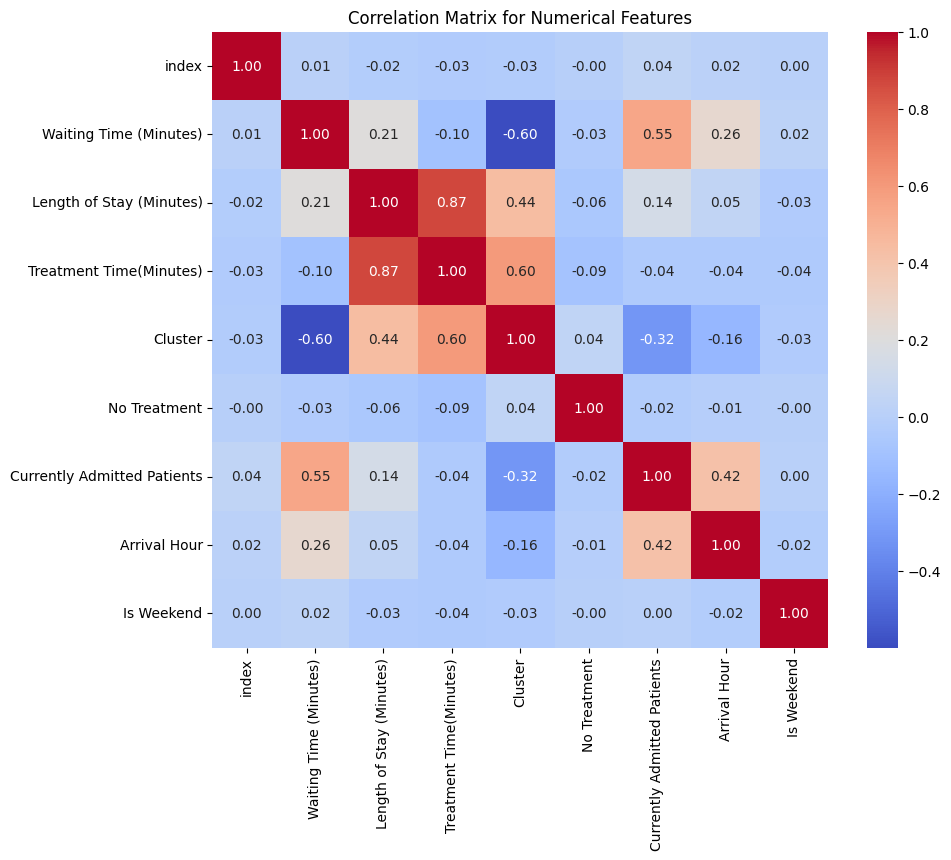

In [8]:
# Step 1: Select only numerical columns
# Convert 'Length of Stay (Minutes)' to numeric, forcing errors to NaN
data['Length of Stay (Minutes)'] = pd.to_numeric(data['Length of Stay (Minutes)'], errors='coerce')

numerical_data = data.select_dtypes(include=['float64', 'int64','int32'])

# Step 2: Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Step 3: Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

In [9]:
def categorize_diagnosis_keywords(diagnosis):
    diagnosis = diagnosis.lower()  # Normalize to lowercase
    # Respiratory
    if re.search(r'upper respiratory|common cold|asthma|cough|dyspnoea|pharyngitis|bronchitis|tonsillitis|wheezing', diagnosis):
        return 'Respiratory Issues'
    # Infectious Diseases
    elif re.search(r'sickle-cell|infection|otitis|conjunctivitis|dysuria|gastroenteritis|covid|flu|fever|viral|bacterial', diagnosis):
        return 'Infectious Diseases'
    # Pain Conditions
    elif re.search(r'pain|chronic pain|abdominal pain|joint pain|myalgia|headache|dysmenorrhoea|pain in limb|pain in back|pain in neck', diagnosis):
        return 'Pain Conditions'
    # Gastrointestinal Issues
    elif re.search(r'constipation|gastritis|nausea|vomiting|colitis|diarrhea|indigestion', diagnosis):
        return 'Gastrointestinal Issues'
    # Musculoskeletal Issues
    elif re.search(r'sprain|strain|arthropathy|contusion|injury|fracture|dislocation|tendinitis|bursitis', diagnosis):
        return 'Musculoskeletal Issues'
    # Neurological Symptoms
    elif re.search(r'palpitations|dizziness|anxiety|fatigue|malaise|vertigo|confusion|seizure|neuropathy', diagnosis):
        return 'Neurological Symptoms'
    # Other General Symptoms
    elif re.search(r'rash|chest pain|allergy|edema|swelling|fatigue|malaise|numbness|tingling', diagnosis):
        return 'Other General Symptoms'
    # Other Conditions
    elif re.search(r'routine|check-up|medical care|pregnancy|prescription|diagnostic|follow-up|screening|evaluation', diagnosis):
        return 'Other Conditions'
    
    return 'Other'  # Default for uncategorized diagnoses

# Apply the updated categorization function
data['Diagnosis Category'] = data['Main Diagnosis'].apply(categorize_diagnosis_keywords)

# Check the new counts
category_counts = data['Diagnosis Category'].value_counts()
print(category_counts)

Diagnosis Category
Respiratory Issues         36143
Pain Conditions            18786
Other                      13057
Infectious Diseases         9330
Other Conditions            6301
Musculoskeletal Issues      3137
Neurological Symptoms       2491
Gastrointestinal Issues     2469
Other General Symptoms      1475
Name: count, dtype: int64


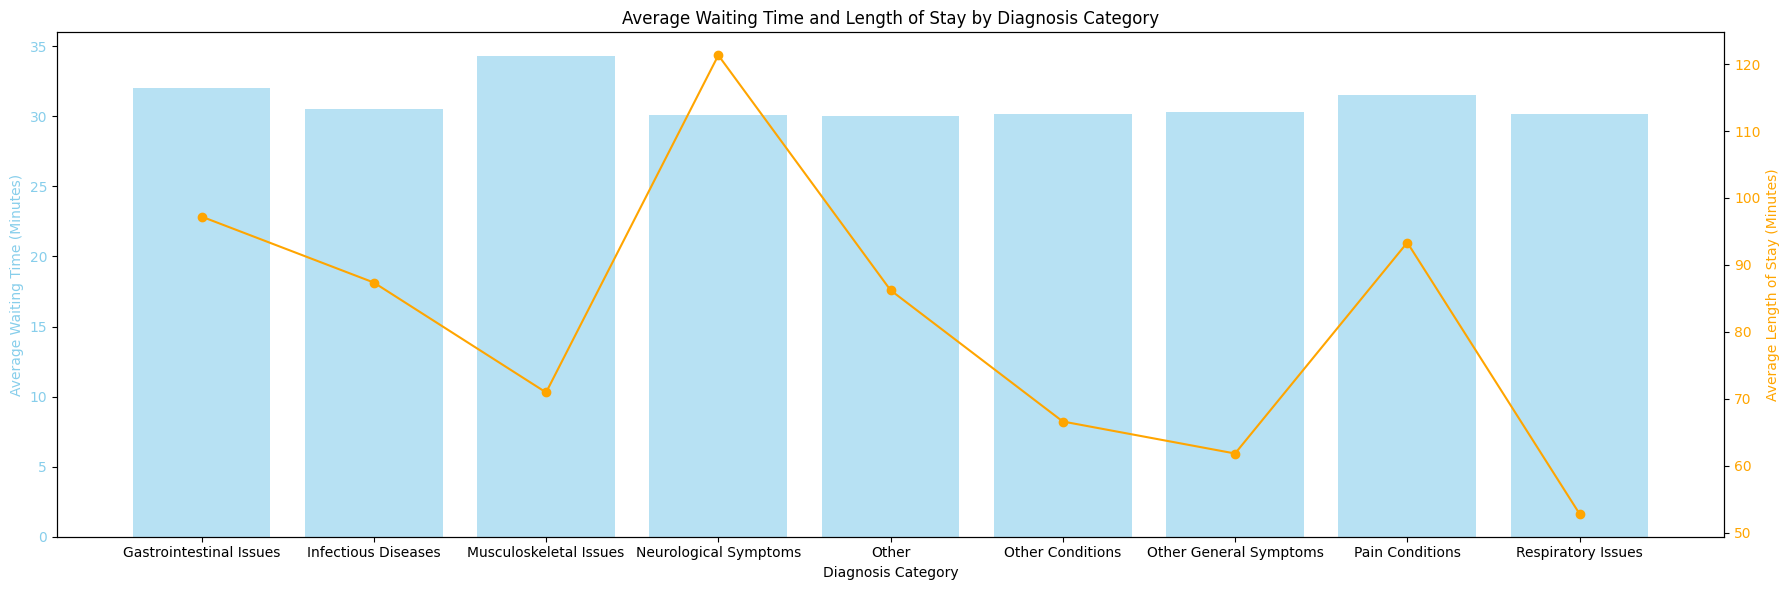

In [10]:
# Average waiting time and length of stay by diagnosis category
avg_waiting_time = data.groupby('Diagnosis Category')[['Waiting Time (Minutes)', 'Length of Stay (Minutes)']].mean().reset_index()

# Set up the figure for visualization
fig, ax1 = plt.subplots(figsize=(18, 6))

# Create a bar chart for waiting time
ax1.bar(avg_waiting_time['Diagnosis Category'], avg_waiting_time['Waiting Time (Minutes)'], color='skyblue', label='Avg Waiting Time', alpha=0.6)
ax1.set_ylabel('Average Waiting Time (Minutes)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create a second y-axis for length of stay
ax2 = ax1.twinx()
ax2.plot(avg_waiting_time['Diagnosis Category'], avg_waiting_time['Length of Stay (Minutes)'], color='orange', marker='o', label='Avg Length of Stay')
ax2.set_ylabel('Average Length of Stay (Minutes)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and labels
plt.title('Average Waiting Time and Length of Stay by Diagnosis Category')
ax1.set_xlabel('Diagnosis Category')
plt.xticks(rotation=45)
fig.tight_layout()  # Adjust layout
plt.show()

In [11]:
# Dropping unnecessary columns
data = data.drop(columns=['ROWNUM', 'Hospital', 'Deparment','Cluster','No Treatment'])

In [12]:
nlp_data = pd.read_csv('../Data/updated_dataset.csv')

#data=pd.read_csv('updated_dataset.csv')
# Display the first few rows to understand the structure
print(nlp_data.head())
nlp_data.shape

                Main Diagnosis  abdominal  abnormal  abrasion  abscess  \
0             pain unspecified          0         0         0        0   
1                    back pain          0         0         0        0   
2  upper respiratory infection          0         0         0        0   
3                    epistaxis          0         0         0        0   
4  upper respiratory infection          0         0         0        0   

   accident  acute  allergy  anaemia  ankle  ...  tract  traumatic  upper  \
0         0      0        0        0      0  ...      0          0      0   
1         0      0        0        0      0  ...      0          0      0   
2         0      0        0        0      0  ...      0          0      1   
3         0      0        0        0      0  ...      0          0      0   
4         0      0        0        0      0  ...      0          0      1   

   urinary  uterine  vaginal  vomit  wheeze  wound  wrist  
0        0        0        0    

(93189, 111)

In [13]:
data = pd.concat([data, nlp_data], axis=1)

In [14]:
# Drop rows with missing values
data.dropna(inplace=True)

# Verify the changes
print(f"Total rows after dropping missing rows: {data.shape[0]}")


Total rows after dropping missing rows: 93189


In [15]:

data.head()

,index,Eligibility Class,Gender,Arrival Time,Severity Level,Main Diagnosis,Discharge Time,Waiting Time (Minutes),Length of Stay (Minutes),Treatment Time(Minutes),...,tract,traumatic,upper,urinary,uterine,vaginal,vomit,wheeze,wound,wrist
0,0,ROYAL COMMISSION,Female,2023-12-13 13:17:48,Level Ⅳ,"Pain, unspecified",2023-12-13 16:43:00,14.0,205.0,191.0,...,0,0,0,0,0,0,0,0,0,0
964,1000,ROYAL COMMISSION,Male,2023-07-29 02:18:43,Level Ⅳ,Constipation,2023-07-29 03:10:00,32.0,51.0,19.0,...,0,0,0,0,0,0,0,0,0,0
965,1001,ROYAL COMMISSION,Male,2023-06-30 20:08:40,Level Ⅳ,Other and unspecified abdominal pain,2023-06-30 21:22:00,58.0,73.0,15.0,...,0,0,0,0,0,0,0,0,0,0
966,1002,ROYAL COMMISSION,Male,2023-06-04 21:45:53,Level Ⅳ,"Fever, unspecified",2023-06-04 22:07:00,18.0,21.0,3.0,...,0,0,0,0,0,0,0,0,0,0
967,1003,ROYAL COMMISSION,Male,2023-04-16 20:07:26,Level Ⅳ,Constipation,2023-04-16 20:55:00,40.0,48.0,8.0,...,0,0,0,0,0,0,0,0,0,0


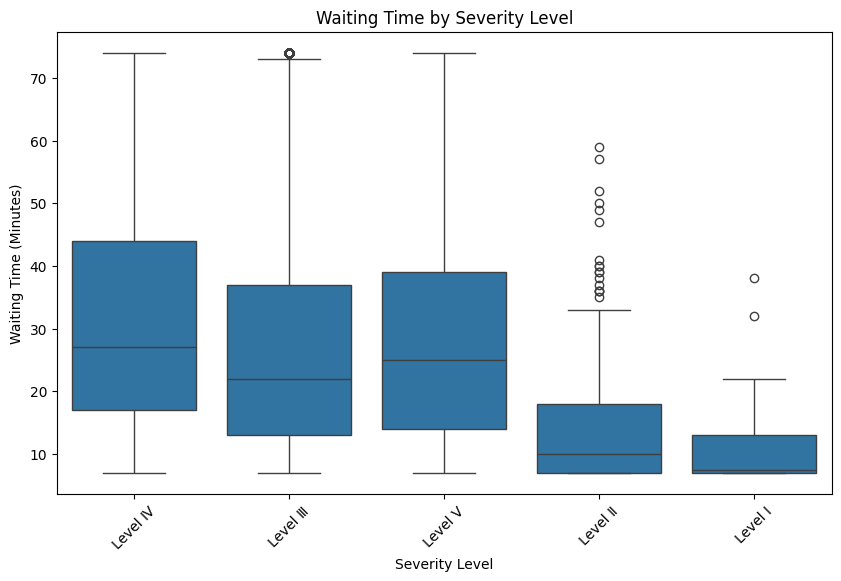

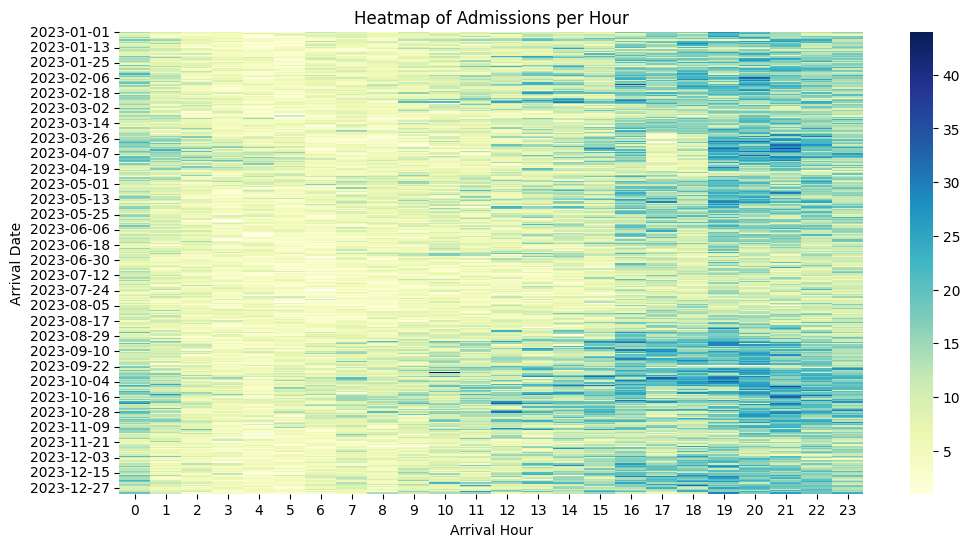

In [16]:
# Plotting Waiting Time by Severity Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity Level', y='Waiting Time (Minutes)', data=data)
plt.title('Waiting Time by Severity Level')
plt.xticks(rotation=45)
plt.show()

# Heatmap for Admissions
admissions_per_hour = data.groupby(['Arrival Date', 'Arrival Hour']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(admissions_per_hour, cmap='YlGnBu')
plt.title('Heatmap of Admissions per Hour')
plt.ylabel('Arrival Date')
plt.xlabel('Arrival Hour')
plt.show()


In [17]:
# Check the data types of the columns
print(data.dtypes)

index                         int64
Eligibility Class            object
Gender                       object
Arrival Time         datetime64[ns]
Severity Level               object
                          ...      
vaginal                       int64
vomit                         int64
wheeze                        int64
wound                         int64
wrist                         int64
Length: 128, dtype: object


Severity Level
Level Ⅰ    11.653846
Level Ⅱ    13.729490
Level Ⅲ    27.409296
Level Ⅳ    32.079678
Level Ⅴ    28.609428
Name: Waiting Time (Minutes), dtype: float64


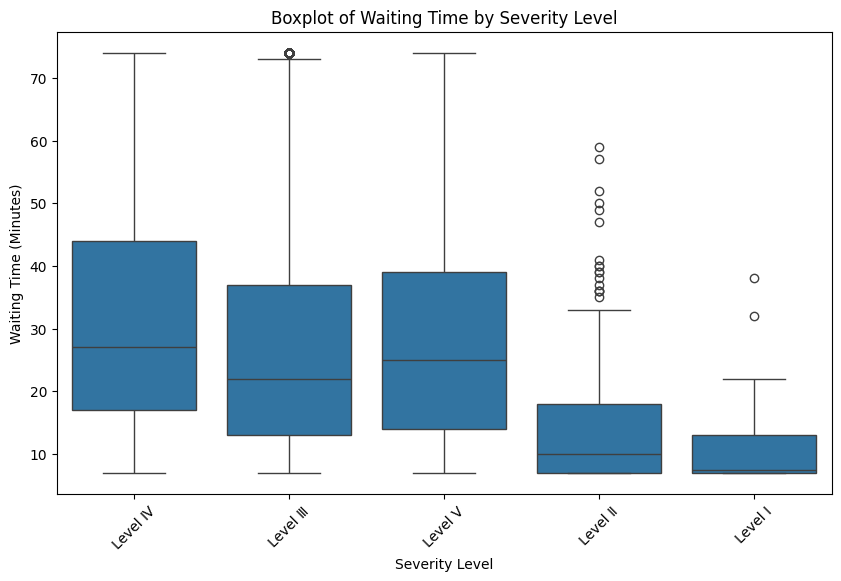

Day of Week
Friday       30.471611
Monday       30.622386
Saturday     31.966307
Sunday       32.021705
Thursday     29.001681
Tuesday      29.565007
Wednesday    30.328727
Name: Waiting Time (Minutes), dtype: float64


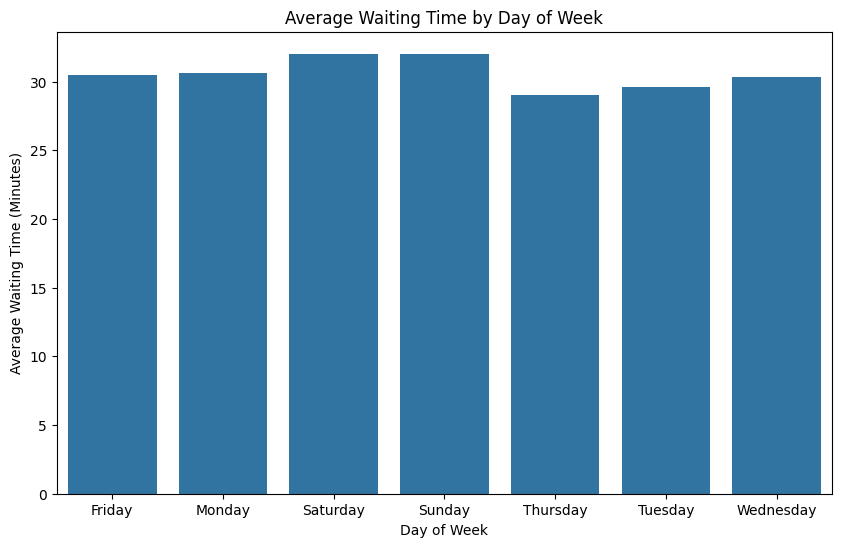

In [18]:
# Average Waiting Time by Severity Level
avg_waiting_severity = data.groupby('Severity Level')['Waiting Time (Minutes)'].mean()
print(avg_waiting_severity)

# Boxplot for Waiting Time by Severity Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity Level', y='Waiting Time (Minutes)', data=data)
plt.title('Boxplot of Waiting Time by Severity Level')
plt.xticks(rotation=45)
plt.show()

# Average Waiting Time by Day of Week
avg_waiting_day = data.groupby('Day of Week')['Waiting Time (Minutes)'].mean()
print(avg_waiting_day)

# Bar plot for average waiting time by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_waiting_day.index, y=avg_waiting_day.values)
plt.title('Average Waiting Time by Day of Week')
plt.ylabel('Average Waiting Time (Minutes)')
plt.xlabel('Day of Week')
plt.show()


Time of Day
Afternoon    32.221953
Evening      36.471442
Morning      21.450620
Night        24.960368
Name: Waiting Time (Minutes), dtype: float64


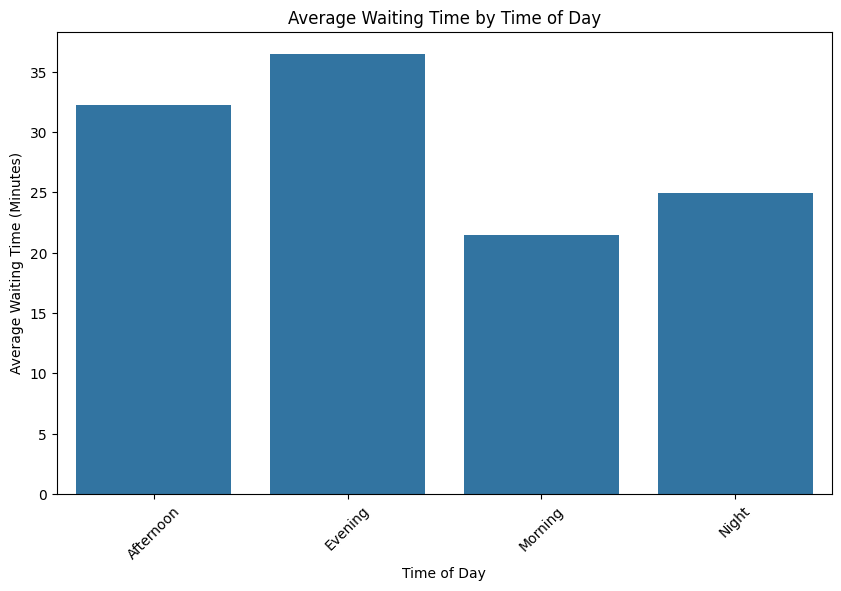

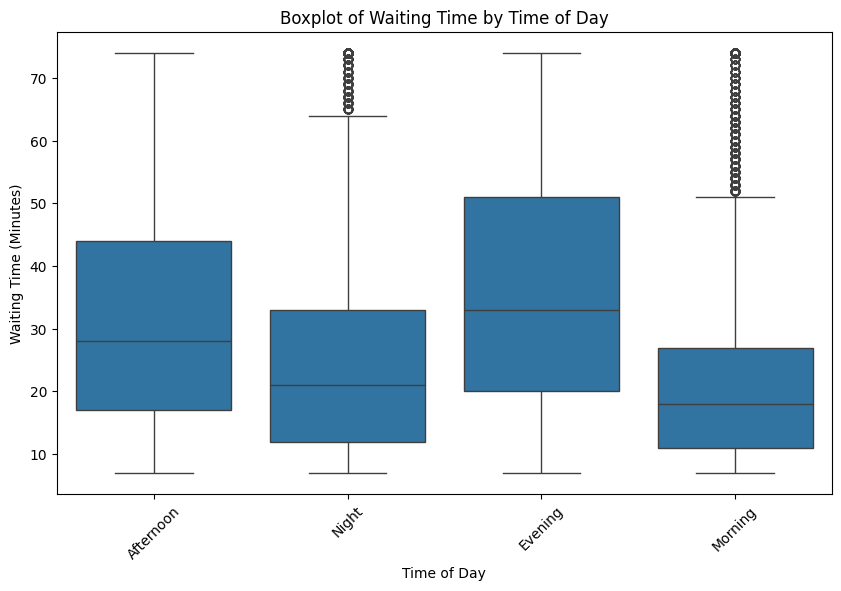

In [19]:
# Average Waiting Time by Time of Day
avg_waiting_time_by_time_of_day = data.groupby('Time of Day')['Waiting Time (Minutes)'].mean()
print(avg_waiting_time_by_time_of_day)

# Bar plot for average waiting time by Time of Day
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_waiting_time_by_time_of_day.index, y=avg_waiting_time_by_time_of_day.values)
plt.title('Average Waiting Time by Time of Day')
plt.ylabel('Average Waiting Time (Minutes)')
plt.xlabel('Time of Day')
plt.xticks(rotation=45)
plt.show()

# Boxplot for Waiting Time by Time of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time of Day', y='Waiting Time (Minutes)', data=data)
plt.title('Boxplot of Waiting Time by Time of Day')
plt.xticks(rotation=45)
plt.show()


In [20]:
# Convert Gender to numerical
gender_mapping = {'Female': 0, 'Male': 1}
data['Gender'] = data['Gender'].map(gender_mapping)


timeDay_map={'Morning':0,'Afternoon':1,'Evening':2,'Night':3}
data['Time of Day'] = data['Time of Day'].map(timeDay_map)


Eligibility_map={'ROYAL COMMISSION':0,'EXEMPT':1,'INSURANCE':2,'CASH':3}
data['Eligibility Class'] = data['Eligibility Class'].map(Eligibility_map)

# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data = data[data['Severity Level'] != 'Unrated']

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)


In [26]:
# Weather Data
weather_data = pd.read_csv('../Data/Jubail_weather_2023 copy.csv')

weather_data.drop(columns=['name'], inplace=True)

weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date
weather_data.rename(columns={'datetime': 'Date'}, inplace=True)
print(weather_data.head())


         Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0  2023-01-01     25.0     17.3  21.7          25.0          17.3       21.7   
1  2023-01-02     25.6     17.2  21.8          25.6          17.2       21.8   
2  2023-01-03     26.0     20.1  22.5          26.0          20.1       22.5   
3  2023-01-04     27.0     19.2  22.6          26.6          19.2       22.6   
4  2023-01-05     28.0     20.1  23.5          27.4          20.1       23.4   

    dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
0  14.4      63.7     0.0  ...         37.4       10         10   
1  13.0      60.1     0.0  ...         35.1       10         10   
2  10.8      48.1     0.0  ...         34.4        9         10   
3   8.4      41.4     0.0  ...         22.8        6         10   
4  10.9      45.7     0.0  ...         16.6        7         10   

               sunrise               sunset  moonphase        conditions  \
0  2023-01-01T07:04:18  2023-01-01T17:39

In [27]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              365 non-null    object 
 1   tempmax           365 non-null    float64
 2   tempmin           365 non-null    float64
 3   temp              365 non-null    float64
 4   feelslikemax      365 non-null    float64
 5   feelslikemin      365 non-null    float64
 6   feelslike         365 non-null    float64
 7   dew               365 non-null    float64
 8   humidity          365 non-null    float64
 9   precip            365 non-null    float64
 10  precipprob        365 non-null    int64  
 11  precipcover       365 non-null    float64
 12  preciptype        34 non-null     object 
 13  snow              365 non-null    int64  
 14  snowdepth         365 non-null    int64  
 15  windgust          365 non-null    float64
 16  windspeed         365 non-null    float64
 1

Selected Columns for Analysis:
- temp: Average temperature, which is crucial for understanding its overall effects on health.
- humidity: High humidity can exacerbate various health issues, influencing ED visits.
- precip: Total precipitation, as wet weather can lead to health-related incidents.
- windspeed: Wind speed can impact outdoor activities and potentially affect health.
- uvindex: Higher UV levels are associated with health risks, such as skin conditions.
- visibility: Reduced visibility can have safety implications, potentially leading to accidents or health emergencies.
- conditions: General weather conditions provide context and may correlate with health impacts.
- description: Specific weather descriptions can capture qualitative data on weather effects, offering additional insights into health outcomes.

In [28]:
# Define the columns to keep
weather_columns= [
    'Date',
    'temp',
    'humidity',
    'windspeed',
    'uvindex',
    'visibility',
    'conditions',
]

# Filter the DataFrame to keep only the selected columns
weather_data = weather_data[weather_columns]

# Display the filtered DataFrame
print(weather_data.head())

         Date  temp  humidity  windspeed  uvindex  visibility  \
0  2023-01-01  21.7      63.7       16.2       10         9.7   
1  2023-01-02  21.8      60.1       17.7       10         8.4   
2  2023-01-03  22.5      48.1       21.6        9        10.0   
3  2023-01-04  22.6      41.4       27.3        6        10.0   
4  2023-01-05  23.5      45.7       20.6        7        10.0   

         conditions  
0             Clear  
1  Partially cloudy  
2  Partially cloudy  
3  Partially cloudy  
4  Partially cloudy  


In [29]:
# Weather Data
# Combine the data with weather data
# Feature 1: Arrival Date
data=data.rename(columns={"Arrival Date":"Date"})
matched_weather = pd.merge(data, weather_data, on='Date', how='inner')
print(matched_weather.head())
matched_weather.shape

   index  Eligibility Class  Gender        Arrival Time  Severity Level  \
0      0                  0       0 2023-12-13 13:17:48               4   
1   1000                  0       1 2023-07-29 02:18:43               4   
2   1001                  0       1 2023-06-30 20:08:40               4   
3   1002                  0       1 2023-06-04 21:45:53               4   
4   1003                  0       1 2023-04-16 20:07:26               4   

                         Main Diagnosis      Discharge Time  \
0                     Pain, unspecified 2023-12-13 16:43:00   
1                          Constipation 2023-07-29 03:10:00   
2  Other and unspecified abdominal pain 2023-06-30 21:22:00   
3                    Fever, unspecified 2023-06-04 22:07:00   
4                          Constipation 2023-04-16 20:55:00   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0   
1         

(93189, 134)

In [31]:
import numpy as np
# Grouping the KTAS classes into emergency (1) and non-emergency (0)
matched_weather["Emergency"] = np.where(matched_weather["Severity Level"] < 4, 1, 0)

In [32]:
# Combine the data with the NLP data
combined_data = matched_weather
# Generate list of NLP feature and time feature columns
feature_columns = nlp_data.columns[1:].tolist()
feature_columns += [
    'Eligibility Class',
    'Emergency', 
    'Arrival Hour', 
    'Currently Admitted Patients', 
    'temp', 
    'humidity', 
    'windspeed', 
    'uvindex', 
    'visibility',
        'Gender',
    'Is Weekend',
    'Time of Day'
]



# Fill missing values with 0 before scaling
combined_data[feature_columns] = combined_data[feature_columns].fillna(0)


# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])
# Scaling the data
df_scaled_features = pd.DataFrame(data=scaled_features, columns=combined_data[feature_columns].columns)

with open('../Models/WT_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

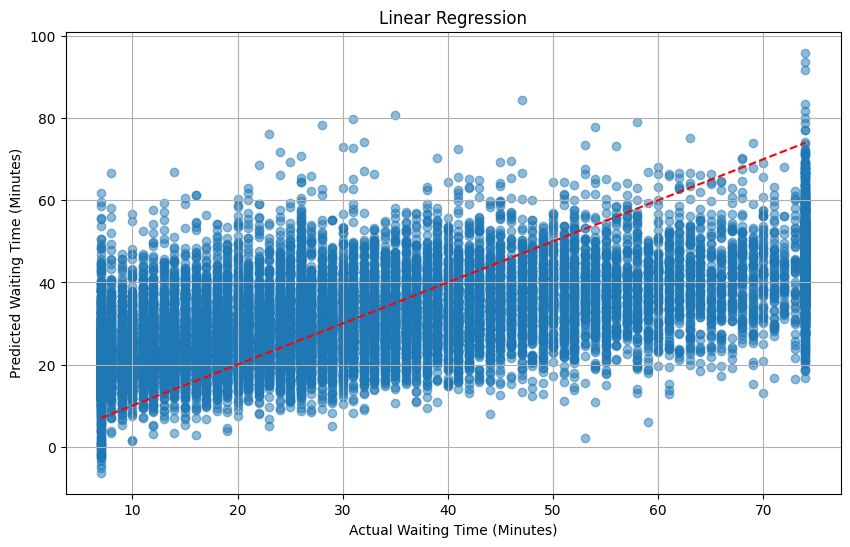

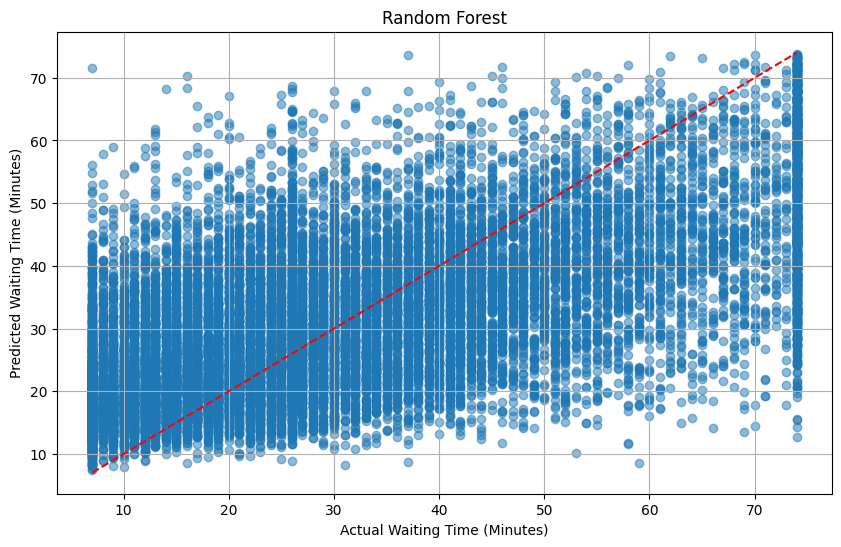

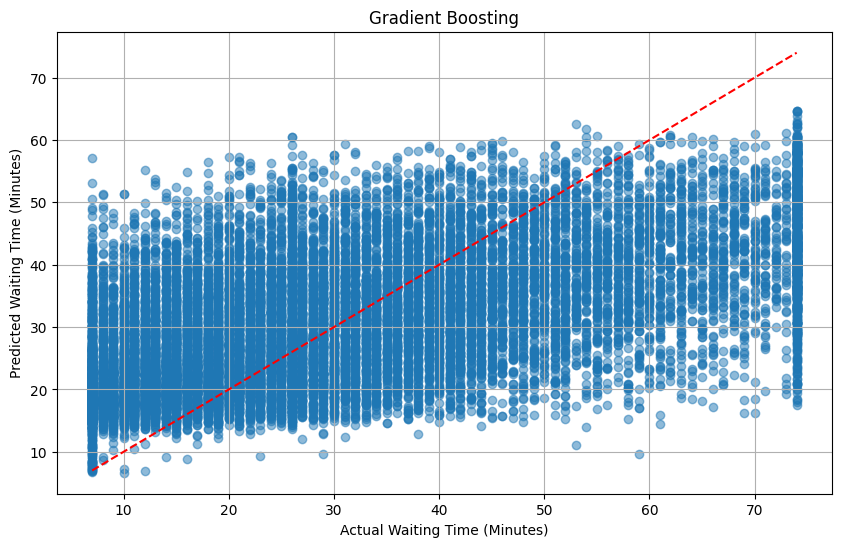

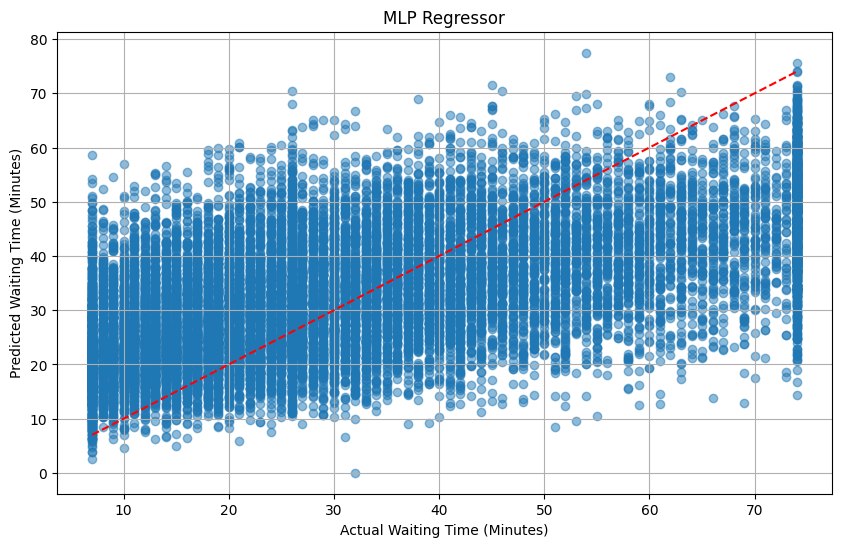

                         MAE         MSE       R^2
Linear Regression  12.337114  243.656855  0.326652
Random Forest      11.415453  217.841067  0.397994
Gradient Boosting  12.170717  236.142812  0.347417
MLP Regressor      12.422903  240.578457  0.335159


In [33]:
# Target variable
target = 'Waiting Time (Minutes)'

# Prepare the features DataFrame
X = df_scaled_features
y = matched_weather[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)  # MLP
}

# Store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
    plt.xlabel('Actual Waiting Time (Minutes)')
    plt.ylabel('Predicted Waiting Time (Minutes)')
    plt.title(model_name)
    plt.grid()
    plt.show()
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # Calculate R^2
    
    # Store results
    results[model_name] = {'MAE': mae, 'MSE': mse, 'R^2': r2}
    

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

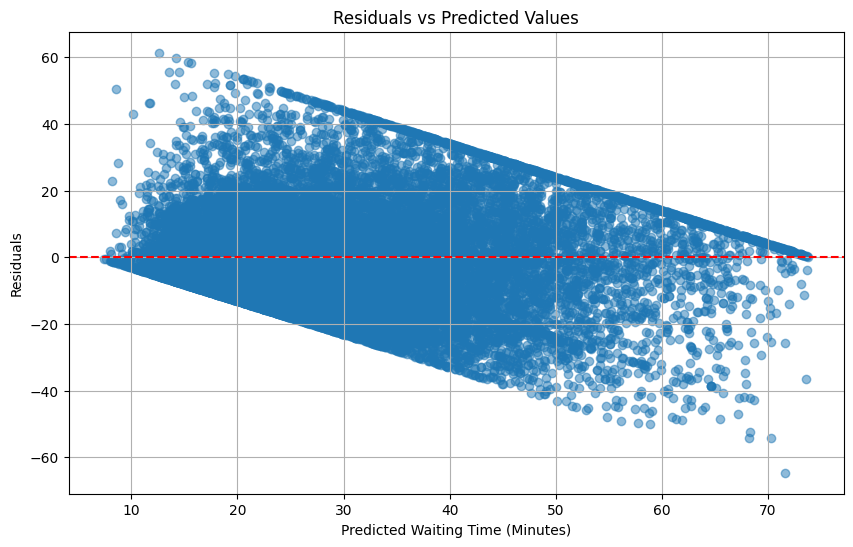

In [34]:
rf=RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')  # Line at zero
plt.xlabel('Predicted Waiting Time (Minutes)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid()
plt.show()

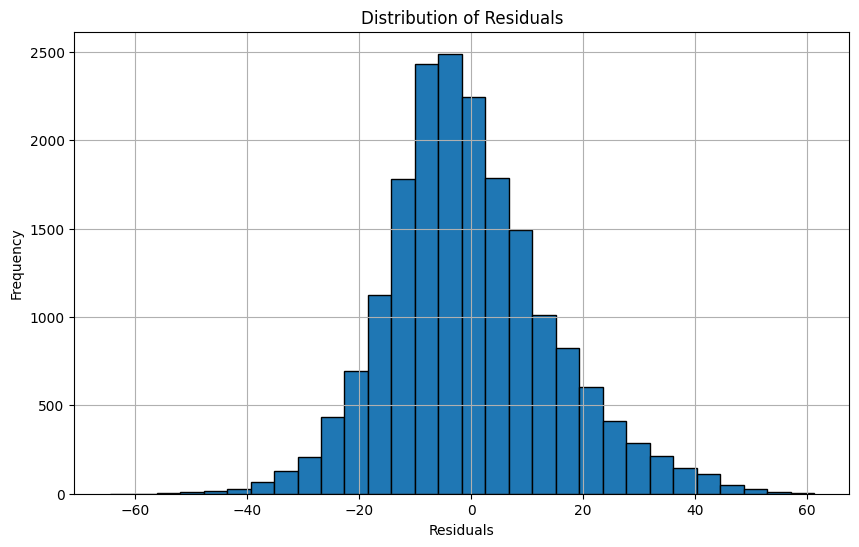

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid()
plt.show()

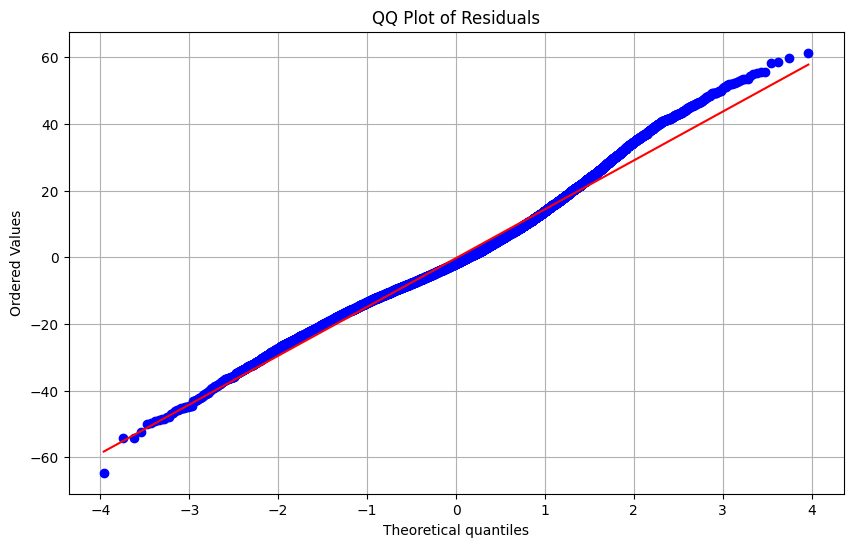

In [36]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid()
plt.show()

In [37]:
# Define a function to plot and print feature importances
def plot_and_print_model_var_imp(model, features):
    # Create a DataFrame for feature importances
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=features
    )
    # Sort the DataFrame by importance
    imp = imp.sort_values(by='Importance', ascending=False)

    # Select the top 10 features
    top_imp = imp.head(15)

    # Plot the top feature importances as a bar chart
    top_imp.plot(kind='barh', figsize=(12, 6))
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance for Random Forest Regressor')
    plt.show()

    # Print the top 10 feature importances
    print(top_imp)

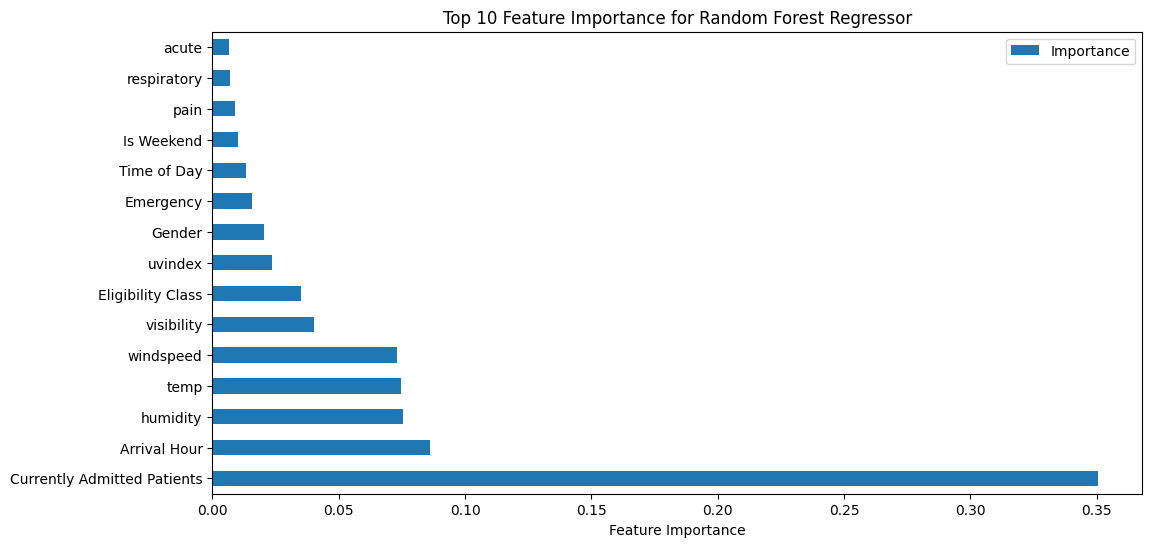

                             Importance
Currently Admitted Patients    0.350565
Arrival Hour                   0.086067
humidity                       0.075628
temp                           0.074593
windspeed                      0.073256
visibility                     0.040047
Eligibility Class              0.035279
uvindex                        0.023700
Gender                         0.020501
Emergency                      0.015611
Time of Day                    0.013450
Is Weekend                     0.010323
pain                           0.008835
respiratory                    0.007165
acute                          0.006783


In [38]:
# Call the function to plot and print feature importances
plot_and_print_model_var_imp(rf, df_scaled_features.columns)

In [39]:
# Save the stacking model
with open('../Models/WT_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [40]:
df_scaled_features

,abdominal,abnormal,abrasion,abscess,accident,acute,allergy,anaemia,ankle,arthropathy,...,Arrival Hour,Currently Admitted Patients,temp,humidity,windspeed,uvindex,visibility,Gender,Is Weekend,Time of Day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565217,0.154930,0.294606,0.494799,0.136508,1.000000,0.641509,0.0,0.0,0.333333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.086957,0.154930,0.867220,0.499257,0.231746,0.777778,0.886792,1.0,1.0,1.000000
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.869565,0.225352,0.821577,0.500743,0.422222,1.000000,0.698113,1.0,1.0,0.666667
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.913043,0.267606,0.713693,0.548291,0.358730,1.000000,0.886792,1.0,0.0,0.666667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.869565,0.140845,0.360996,0.549777,0.530159,1.000000,0.886792,1.0,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043478,0.253521,0.817427,0.570579,0.298413,0.777778,0.452830,0.0,1.0,1.000000
93185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.695652,0.197183,0.937759,0.289747,0.507937,0.777778,0.566038,0.0,1.0,0.333333
93186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.347826,0.126761,0.792531,0.656761,0.298413,0.777778,0.735849,1.0,0.0,0.000000
93187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.347826,0.112676,0.829876,0.520059,0.320635,1.000000,0.792453,1.0,1.0,0.000000


In [41]:
def make_prediction(diagnosis,eligibility,Emergency,hour, no_patients, temp,humidity,windspeed,uvindex,visibility,gender,Is_Weekend,Time_Day):
    data = {
        "Main Diagnosis": [diagnosis],
        'Eligibility Class':[eligibility],
        'Emergency':[Emergency], 
        'Arrival Hour':[hour],
        "Currently Admitted Patients": [no_patients],
        "temp": [temp],
        "humidity": [humidity],
        "windspeed": [windspeed],
        "uvindex":[uvindex],
        "visibility":[visibility],
        "Gender":[gender],
        "Is Weekend":[Is_Weekend],
        "Time of Day":[Time_Day]
    }


    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])
    with open('../Models/nlp_diagnosis.pkl', 'rb') as file:
        vectorizer = pickle.load(file)

    
    df_new_encoded = vectorizer.transform(df_new['Main Diagnosis'])
    df_new_features = pd.DataFrame(df_new_encoded.toarray(), columns=vectorizer.get_feature_names_out())
    #print(df_new_features)

    df_new["Eligibility Class"]=df_new["Eligibility Class"].replace({'ROYAL COMMISSION':0,'EXEMPT':1,'INSURANCE':2,'CASH':3})
    df_new["Gender"]=df_new["Gender"].replace({'Female': 0, 'Male': 1})
    df_new["Is Weekend"] = df_new["Is Weekend"].replace({'no': 0, 'yes': 1})
    df_new["Time of Day"]= df_new["Time of Day"].replace({'Morning':0,'Afternoon':1,'Evening':2,'Night':3})
    
    # Combine all features into one DataFrame
    df_new=df_new.drop(columns=['Main Diagnosis'])
    #print(df_new.info())
    df_final = pd.concat([df_new_features, df_new], axis=1)


    with open('../Models/WT_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    
    scaled_data=scaler.fit(df_final)
    
    with open('../Models/WT_model.pkl', 'rb') as file:
        wt_model = pickle.load(file)
    
    # Predict using the Random Forest model
    prediction = wt_model.predict(df_final)
    
    # Return the prediction result

    return prediction


In [42]:
make_prediction('open wound of other parts of wrist and hand', 'CASH',1,8, 12,21.7,63.7,16.2,10,9.7,'Female','yes','Morning')

array([36.15])